# Predicting a country's continent from stylistic features of its national flag 

Author: Ian S. McBride

Within this notebook, a classification task was performed using a K-nearest neighbors classifier and K-fold cross-validation. The predictive ability of the classifier was evaluated by calculating a classification report and confusion matrix.

Datasets used: http://archive.ics.uci.edu/ml/datasets/Flags

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Read csv file and display summary info
flag_full = pd.read_csv('datasets/flags.csv')
print('Columns:', flag_full.columns)
display(flag_full.info())
display(flag_full.head())

Columns: Index(['name', 'landmass', 'zone', 'area', 'population', 'language',
       'religion', 'bars', 'stripes', 'colours', 'red', 'green', 'blue',
       'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses',
       'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon',
       'animate', 'text', 'topleft', 'botright'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
name          194 non-null object
landmass      194 non-null int64
zone          194 non-null int64
area          194 non-null int64
population    194 non-null int64
language      194 non-null int64
religion      194 non-null int64
bars          194 non-null int64
stripes       194 non-null int64
colours       194 non-null int64
red           194 non-null int64
green         194 non-null int64
blue          194 non-null int64
gold          194 non-null int64
white         194 non-null int64
black         194 non-nul

None

name  landmass  zone  area  population  language  religion  bars  \
0     Afghanistan         5     1   648          16        10         2     0   
1         Albania         3     1    29           3         6         6     0   
2         Algeria         4     1  2388          20         8         2     2   
3  American-Samoa         6     3     0           0         1         1     0   
4         Andorra         3     1     0           0         6         0     3   

   stripes  colours    ...     saltires  quarters  sunstars  crescent  \
0        3        5    ...            0         0         1         0   
1        0        3    ...            0         0         1         0   
2        0        3    ...            0         0         1         1   
3        0        5    ...            0         0         0         0   
4        0        3    ...            0         0         0         0   

   triangle  icon  animate text  topleft  botright  
0         0     1        0    0    black     green  
1         0     0        1    0      red       red  
2         0     0        0    0    green     white  
3         1     1        1    0     blue       red  
4         0     0        0    0     blue       red  

[5 rows x 30 columns]

In [3]:
# List columns that will serve as features
flag_attr = [
    'bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold',
    'white', 'black', 'orange', 'mainhue', 'circles', 'crosses',
    'saltires', 'quarters', 'sunstars', 'crescent', 'triangle',
    'icon', 'animate', 'text', 'topleft', 'botright'
]

# Store id to name mapping for landmasses
landmasses = {
    1: 'N.America', 2: 'S.America', 3: 'Europe', 4: 'Africa',
    5: 'Asia', 6: 'Oceania'
}

In [4]:
# Examine one full row of data
flag_full.iloc[0]

name          Afghanistan
landmass                5
zone                    1
area                  648
population             16
language               10
religion                2
bars                    0
stripes                 3
colours                 5
red                     1
green                   1
blue                    0
gold                    1
white                   1
black                   1
orange                  0
mainhue             green
circles                 0
crosses                 0
saltires                0
quarters                0
sunstars                1
crescent                0
triangle                0
icon                    1
animate                 0
text                    0
topleft             black
botright            green
Name: 0, dtype: object

### Some flag attributes need preprocessing

`mainhue`, `topleft`, `botright` should be converted to numberic values using `get_dummies()`.

In [5]:
# Extract features and preprocess categorical features
features = flag_full[flag_attr]
features = pd.get_dummies(features, drop_first=True)
print(features.columns)

# Extract target variable
target = flag_full['landmass']

Index(['bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white',
       'black', 'orange', 'circles', 'crosses', 'saltires', 'quarters',
       'sunstars', 'crescent', 'triangle', 'icon', 'animate', 'text',
       'mainhue_blue', 'mainhue_brown', 'mainhue_gold', 'mainhue_green',
       'mainhue_orange', 'mainhue_red', 'mainhue_white', 'topleft_blue',
       'topleft_gold', 'topleft_green', 'topleft_orange', 'topleft_red',
       'topleft_white', 'botright_blue', 'botright_brown', 'botright_gold',
       'botright_green', 'botright_orange', 'botright_red', 'botright_white'],
      dtype='object')


In [6]:
# Prepare variables for use with Seaborn
combined = pd.concat([features, target], axis=1)
vars_colors = ['colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange']
vars_shapes = ['bars', 'stripes', 'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 'crescent', 'triangle',]
vars_mainhue = ['mainhue_blue', 'mainhue_brown', 'mainhue_gold', 'mainhue_green', 'mainhue_orange', 'mainhue_red', 'mainhue_white']

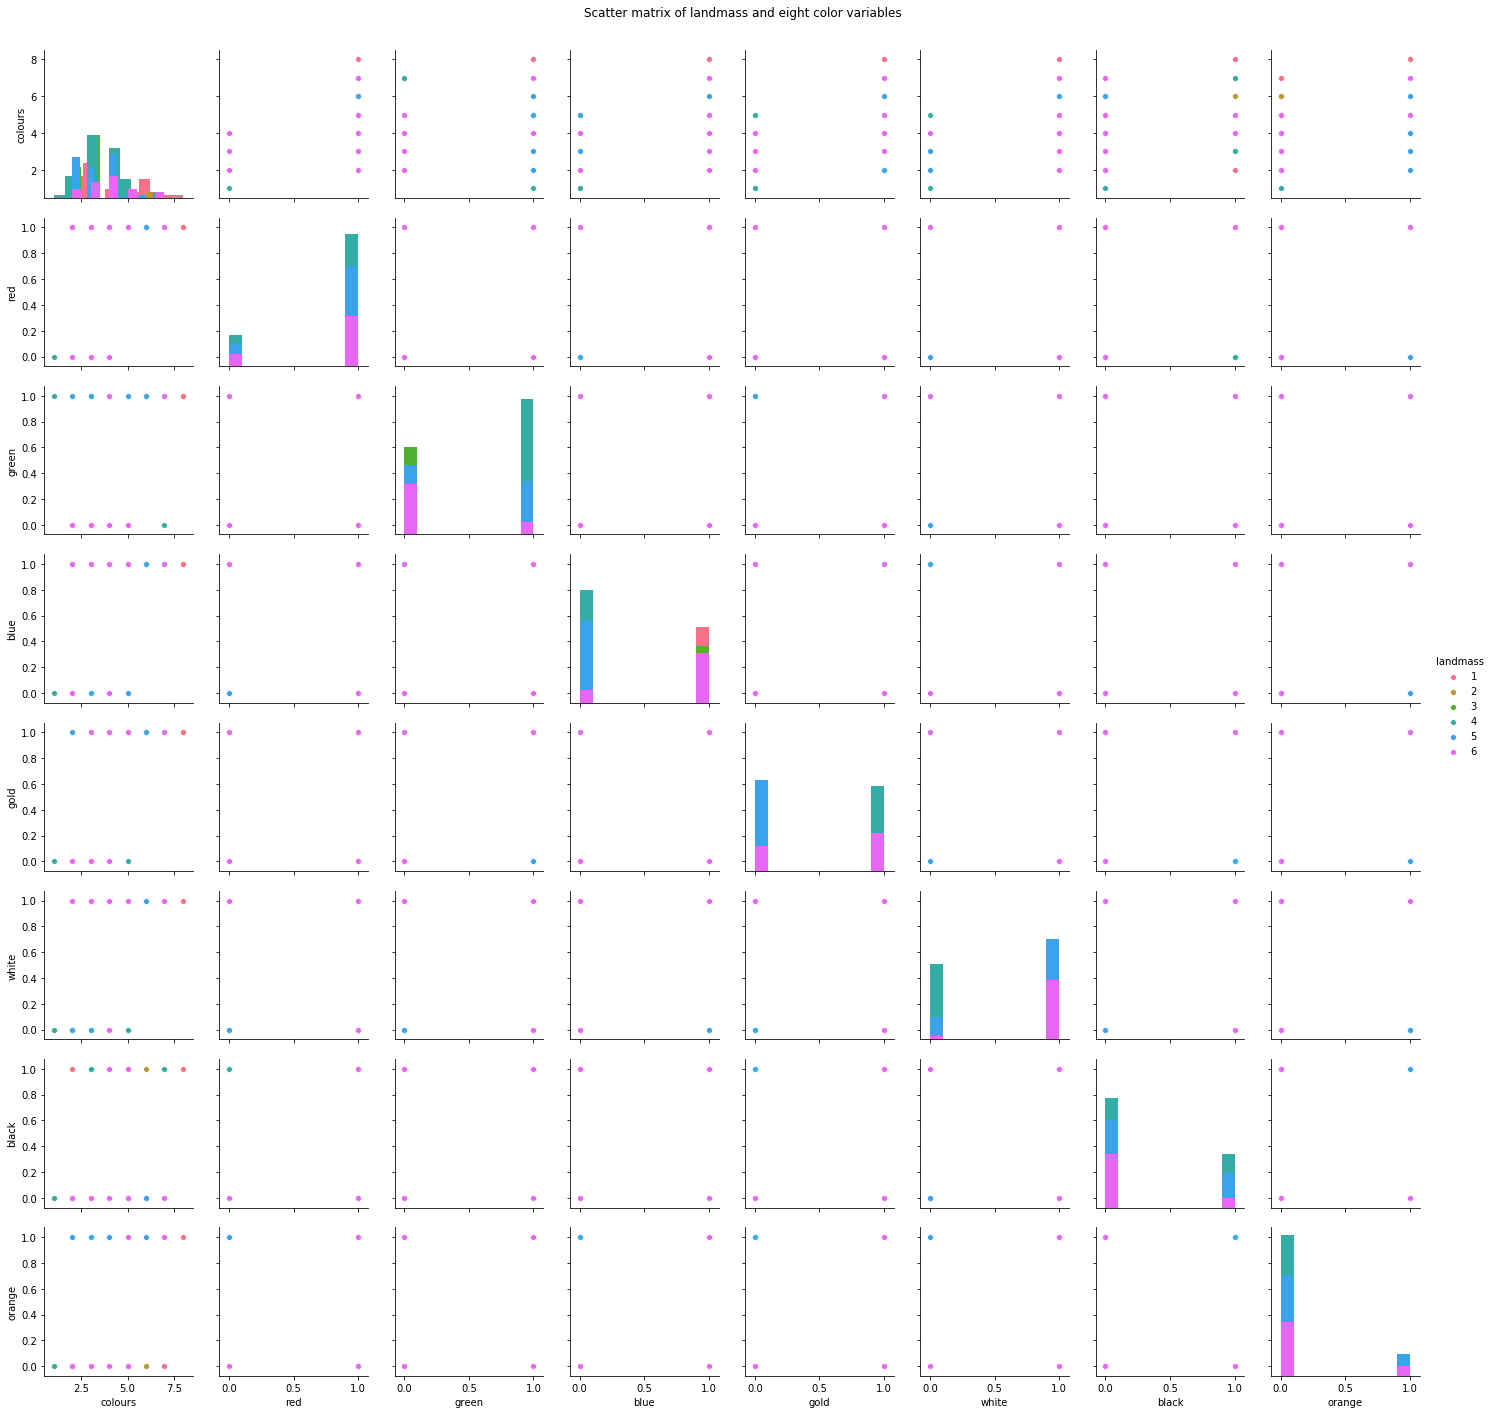

In [7]:
# Plot a scatter matrix of the color variables
g = sns.pairplot(
    data=combined,
    vars=vars_colors,
    hue='landmass',
    diag_kind='hist',
    palette="husl"
)

plt.subplots_adjust(top=0.95)
_ = g.fig.suptitle('Scatter matrix of landmass and eight color variables')

## Interpreting the above scatter matrix

Plotting a scatter matrix wasn't helpful because the number of features (29) was high and the features had discrete values when small ranges.

In [8]:
# Split data into train/test sets
X = features.values
y = target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [9]:
# Create model, create grid for hyperparamater searching, and fit the model  
param_grid = {'n_neighbors': np.arange(3,16)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

/mnt/storage/dev/envs/python/tmp/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
# Display model fitting results
print('best_params:', knn_cv.best_params_)
print('best_score:', knn_cv.best_score_)

best_params: {'n_neighbors': 12}
best_score: 0.4064516129032258


In [11]:
# Predict the test labels
y_pred = knn_cv.predict(X_test)

In [12]:
# Display model prediction results
print('score:', knn_cv.score(X_test, y_test))
print(classification_report(y_test, y_pred))

score: 0.5128205128205128
              precision    recall  f1-score   support

           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         2
           3       0.64      0.88      0.74         8
           4       0.64      0.54      0.58        13
           5       0.29      0.40      0.33         5
           6       0.75      0.50      0.60         6

   micro avg       0.51      0.51      0.51        39
   macro avg       0.41      0.42      0.41        39
weighted avg       0.52      0.51      0.50        39



/mnt/storage/dev/envs/python/tmp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Intepreting model results

From the classification report, it's clear that flags from landmasses 3, 4, and 6 (Europe, Africa, and Oceania respectively) were predicted best. It's unclear what went wrong with landmass 2 (South America) and why it had a precision of 0.0. Overall, the precision score was 0.51, which isn't very strong.